In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import sys, getopt
import csv
import pickle
import copy

from tqdm import tqdm


pd.set_option('display.max_rows', 500)

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline  
import seaborn as sns
sns.set_style("darkgrid")

import umap
from sklearn.decomposition import TruncatedSVD as tsvd

def nearZeroVarDropAuto(df,thresh=0.99):
    vVal=df.var(axis=0).values
    cs=pd.Series(vVal).sort_values(ascending=False).cumsum()
    remove=cs[cs>cs.values[-1]*thresh].index.values
    return df.drop(df.columns[remove],axis=1)

%run SodaKick_download_functions.ipynb


import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD, Adagrad, Adam, Adagrad
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class EarlyStopping:

    """ Stops the training if loss doesn't improve after a given number of epochs. """

    def __init__(self, patience=3, epsilon=1e-5, keepBest=True, silent=True):

        """
        Args:
            patience (int): Number of epochs without change before stopping the learning (default 3).
            epsilon (float): Minimum change in loss to be considered for early stopping (default 1e-5).
            keepBest (bool): Keep track of the best model (memory consuming).
        """

        self.patience = patience
        self.epsilon = epsilon
        self.counter = 0
        
        self.bestScore = np.inf
     
        self.keepBest = keepBest 
        self.bestModel = None

        self.earlyStop = False
        self.silent = silent

    def __call__(self, loss, model):


        """ Evaluate the loss change between epochs and activates early stop if below epsilon.

        Args:
            loss (float): current loss.
            model (torch model): the current model.
        """

        if loss > self.bestScore - self.epsilon:

            self.counter += 1
            if not self.silent:
                print('EarlyStopping counter: {:d}/{:d}'.format(self.counter,self.patience))

            if self.counter >= self.patience:
                self.earlyStop = True

        else:   

            self.counter = 0
            self.bestScore = loss

            if self.keepBest:
                self.bestModel = copy.deepcopy(model)


In [4]:
class matchesDataset(Dataset):

    """ Extend pytorch Dataset class to include cleaning and training set creation, """
    
    def __init__(self, matches, results):

        self.matches = torch.tensor(matches, dtype=torch.float32)
        self.results = torch.tensor(results, dtype=torch.float32)

    def __len__(self):

        """ Returns the len of the training sample. """
        
        return len(self.matches)
        

    def __getitem__(self, index): 

        """ Returns a word, a context word and a list of negative words for training for a given index. 

        Args:
            index (int): index for the word selection.

        Returns:
            (string, string, list of strings): selected word, context word and a randomly drawn list 
                                               of negative words.

        """
        return self.matches[index], self.results[index]
    
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 4}

In [5]:
#https://towardsdatascience.com/quirky-keras-custom-and-asymmetric-loss-functions-for-keras-in-r-a8b5271171fe
def WSE(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      b*torch.maximum(torch.zeros(output.shape[1]),output - target)**2)      
    return loss

def WSEl1(output, target, a=1.5, b=.5):
    loss = torch.mean(a*torch.abs(torch.minimum(torch.zeros(output.shape[1]),output - target))+\
                      b*torch.abs(torch.maximum(torch.zeros(output.shape[1]),output - target)))      
    return loss

def WSE2(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.minimum(np.zeros(output.shape[0]),output - target)**2+\
                      b*np.maximum(np.zeros(output.shape[0]),output - target)**2)      
    return loss

def WSEl12(output, target, a=1.5, b=.5):
    loss = np.mean(a*np.abs(np.minimum(np.zeros(output.shape[0]),output - target))+\
                      b*np.abs(np.maximum(np.zeros(output.shape[0]),output - target)))      
    return loss

In [6]:
from sklearn import preprocessing

    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2a.pkl', 'rb') as pk:
    inp=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2a.pkl', 'rb') as pk:
    out=pickle.load(pk)     
    
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_inp_2b.pkl', 'rb') as pk:
    inpb=pickle.load(pk)
with open(r'/Users/federico comitani/GitHub/sodakick/data/10leagues_out_2b.pkl', 'rb') as pk:
    outb=pickle.load(pk)     

inp=np.concatenate([inp,inpb])
out=np.concatenate([out,outb])

def normalize_mins(vec):
    for i in range(vec.shape[0]):
        vec[i][::8]=vec[i][::8]/90

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def NormalizeMatrix(data):   
    for i in range(data.shape[1]):
        data[:,i] = NormalizeData(data[:,i])
        
NormalizeMatrix(inp)
np.nan_to_num(inp, copy=False)

normalize_mins(out)

#scaler = preprocessing.StandardScaler().fit(inp)
#inp = scaler.transform(inp)

//miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [7]:
def train(x_train, y_train, x_test, y_test, net, optimizer, loss_func, epochs, earlStop, clip=False, silent=True):
    
    phases = ['train']
    
    training_set = matchesDataset(x_train, y_train)
    trainBatch = torch.utils.data.DataLoader(training_set, **params)

    if x_test is not None and y_test is not None:
        phases.append('val')
        validation_set = matchesDataset(x_test, y_test)
        valBatch = torch.utils.data.DataLoader(validation_set, **params)

    losses=[[],[]]
    mses=[]
    diffs=[]
    exit=False
    #for epoch in tqdm(range(epochs), desc='Epoch'):
    for epoch in range(epochs):

        if exit:
            break
        
        for phase in phases:
            if phase == 'train':
                net.train(True)  # Set model to training mode

                """ Run the training of the model. """    

                losses_batch=[]
                #pBarB = tqdm(enumerate(trainBatch), total=len(trainBatch),  desc='Batch')
                #for batchNum, batch in pBarB:
                for batchNum, batch in enumerate(trainBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """
                    
                    loss = loss_func(net(x), y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    if clip:
                        net.clp()

                    losses_batch.append(loss)
                    #pBarB.set_postfix({'train loss' : '{:.5f}'.format(loss.item())})

                """ Early stop check. """

                earlStop(loss, net)
                finalepoch = epoch
                
                if earlStop.earlyStop:

                    if not silent:
                        print('Limit loss improvement reached, stopping the training.')
                        
                    exit=True 
                
                losses[0].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
            else:
                net.train(False)
                net.eval()
      
                mses_batch=[]
                diff_batch=[]
                losses_batch=[]
                #pBarB = tqdm(enumerate(valBatch), total=len(valBatch),  desc='Batch')
                #for batchNum, batch in pBarB:
                for batchNum, batch in enumerate(valBatch):

                    x = batch[0]
                    y = batch[1]

                    """ Move batches to GPU if available. """

                    if torch.cuda.is_available():
                        x = x.cuda()
                        y = y.cuda()

                    """ Core of training. """

                    
                    optimizer.zero_grad()
                    output=net(x)
                    target=y
                    loss = loss_func(output, target)

                    mses_batch.append(torch.mean(torch.minimum(torch.zeros(output.shape[1]),output - target)**2+\
                      torch.maximum(torch.zeros(output.shape[1]),output - target)**2)  )
                    losses_batch.append(loss)
                    diff_batch.append(output-target)
                    
                    #pBarB.set_postfix({'val loss' : '{:.5f}'.format(loss.item())})
                losses[1].append(torch.mean(torch.stack(losses_batch)).detach().cpu().numpy())
                    
                mses.append(torch.mean(torch.stack(mses_batch)).detach().cpu().numpy())
                diffs.append(torch.mean(torch.cat(diff_batch, dim=0), dim=0).detach().cpu().numpy())
        
    return losses, finalepoch, mses, diffs, net

In [8]:
def revert_output(output,lineup):

    reframe=pd.DataFrame(output.reshape(50,8), index=lineup.index,
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
    byteamframe=pd.concat([reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==0].index]].sum(axis=0),
                        reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==1].index]].sum(axis=0)], axis=1).T
    
    reframe['minutes']=reframe['minutes']*90
    
    return reframe, byteamframe[byteamframe.columns[1:]]
    

# cross valid

In [9]:
from sklearn.model_selection import KFold

def runKfold(indata, outdata, model, loss_func, clip=False, epochs=100, optim='adam', patience=10, lr=0.001):
    
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(indata)

    trlosses=[]
    losses=[]
    ec=[]
    mss=[]
    diffs=[]
    
    for train_index, test_index in kf.split(indata):
        earlStop = EarlyStopping(patience=patience, keepBest=False)
        net = model(indata, outdata)
        
        if optim=='adam':
            optimizer = Adam(net.parameters(), lr=lr)
        elif optim=='adagrad':
            optimizer = Adagrad(net.parameters(), lr=lr)
        else:
            print('optim error')
            return
        
        x_train, y_train, x_test, y_test = indata[train_index], outdata[train_index], indata[test_index], outdata[test_index]
        
        ls, ep, ms, df, net = train(x_train, y_train, x_test, y_test, net=net, optimizer=optimizer, loss_func=loss_func, epochs=epochs, earlStop=earlStop, clip=clip)
        
        trlosses.append(ls[0])
        losses.append(ls[1])

        ec.append(ep)
        mss.append(ms)
        diffs.append(df)
        
        errs=[np.mean([np.mean(x.reshape(-1, 50), axis=1) for x in diffs[y]], axis=0) for y in range(len(diffs))]
        meaerrs=np.mean(errs, axis=0)
        meastd=np.std(errs, axis=0)
        
    print('Epochs: {:.3f}+/-{:.3f}'.format(np.mean(ec),np.std(ec)))
    print('KFold Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in losses]),np.std([np.mean(x) for x in losses])))
    print('MSE Result: {:.3f}+/-{:.3f}'.format(np.mean([np.mean(x) for x in mss]),np.std([np.mean(x) for x in mss])))
    return [trlosses,losses], net, meaerrs, meastd, net

In [10]:
class Net1(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], 750)
        self.lr1 = nn.LeakyReLU()
        self.hid2 = nn.Linear(750, 500)
        self.lr2 = nn.LeakyReLU()
        self.oupt = nn.Linear(500, y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.hid1(x)) #tanh original
        z = self.lr2(self.hid2(z)) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [11]:
class Net1shallow(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1shallow, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], 500)
        self.lr1 = nn.LeakyReLU()
        self.oupt = nn.Linear(500, y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.hid1(x)) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [12]:
class Net1deep(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1deep, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], 750)
        self.lr1 = nn.LeakyReLU()
        self.hid2 = nn.Linear(750, 500)
        self.lr2 = nn.LeakyReLU()
        self.hid3 = nn.Linear(500, 500)
        self.lr3 = nn.LeakyReLU()
        self.oupt = nn.Linear(500, y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.hid1(x)) #tanh original
        z = self.lr2(self.hid2(z)) #tanh original
        z = self.lr3(self.hid3(z)) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [13]:
class Net1deeplarge(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1deeplarge, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lr1 = nn.LeakyReLU()
        self.hid2 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lr2 = nn.LeakyReLU()
        self.hid3 = nn.Linear(x_train.shape[1], 500)
        self.lr3 = nn.LeakyReLU()
        self.oupt = nn.Linear(500, y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.hid1(x)) #tanh original
        z = self.lr2(self.hid2(z)) #tanh original
        z = self.lr3(self.hid3(z)) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [14]:
class Net1large(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1large, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lr1 = nn.LeakyReLU()
        self.hid2 = nn.Linear(x_train.shape[1], x_train.shape[1])
        self.lr2 = nn.LeakyReLU()
        self.oupt = nn.Linear(x_train.shape[1], y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.hid1(x)) #tanh original
        z = self.lr2(self.hid2(z)) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))

In [15]:
class Net1dp(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1dp, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], 750)
        self.dp1 = nn.Dropout(p=0.2)
        self.lr1 = nn.LeakyReLU()
        self.hid2 = nn.Linear(750, 500)
        self.dp2 = nn.Dropout(p=0.2)
        self.lr2 = nn.LeakyReLU()
        self.oupt = nn.Linear(500, y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.dp1(self.hid1(x))) #tanh original
        z = self.lr2(self.dp2(self.hid2(z))) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))
            
class Net1bn(nn.Module):
    
    def __init__(self, x_train, y_train):
        super(Net1bn, self).__init__()
        self.hid1 = nn.Linear(x_train.shape[1], 750)
        self.bn1 = torch.nn.BatchNorm1d(750)
        self.lr1 = nn.LeakyReLU()
        self.hid2 = nn.Linear(750, 500)
        self.bn2 = torch.nn.BatchNorm1d(500)
        self.lr2 = nn.LeakyReLU()
        self.oupt = nn.Linear(500, y_train.shape[1])
    
    def forward(self, x):
        z = self.lr1(self.bn1(self.hid1(x))) #tanh original
        z = self.lr2(self.bn2(self.hid2(z))) #tanh original
        z = self.oupt(torch.tanh(z))
        # no softmax. see CrossEntropyLoss() 
        #you can return the loss if you wish here (see skipgram)
        return z
    
    def clp(self):
        with torch.no_grad():
            self.hid1.weight.copy_ (self.hid1.weight.data.clamp(min=0)) 
            self.oupt.weight.copy_ (self.oupt.weight.data.clamp(min=0))
            
                        

In [16]:
print('Baseline WSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline WSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0])))
print('Baseline MSE: {:.3f}'.format(WSE2(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))
print('Baseline MSE l1: {:.3f}'.format(WSEl12(np.array([0]*out[0].shape[0]),out[0], a=1, b=1)))



print((out[1]-out[10]).sum())
print((out[50]-out[60]).sum())
print((out[100]-out[110]).sum())

Baseline WSE: 0.230
Baseline WSE l1: 0.139
Baseline MSE: 0.153
Baseline MSE l1: 0.092
-18.0
16.566666666666666
2.0000000000000004


In [17]:
inptmp=inp[:500]
outtmp=out[:500]

Epochs: 19.000+/-3.162
KFold Result: 0.056+/-0.002
MSE Result: 0.056+/-0.002
-0.7377448
0.90267265
-1.2294345


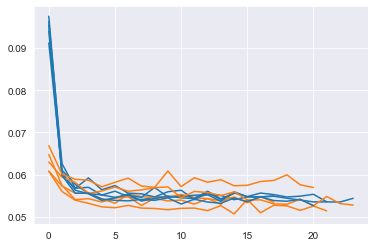

In [18]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1, nn.MSELoss())
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 27.800+/-17.725
KFold Result: 0.055+/-0.004
MSE Result: 0.055+/-0.004
-4.765075
4.469399
-4.8253183


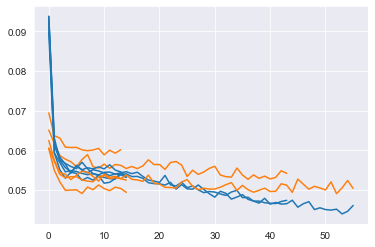

In [19]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1shallow, nn.MSELoss())
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 32.200+/-15.766
KFold Result: 0.055+/-0.003
MSE Result: 0.055+/-0.003
1.7819804
1.615328
-3.9673657


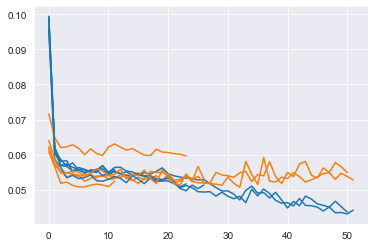

In [197]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1deep, nn.MSELoss())
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 29.600+/-10.688
KFold Result: 0.055+/-0.002
MSE Result: 0.055+/-0.002
-4.160512
6.7833347
-5.894017


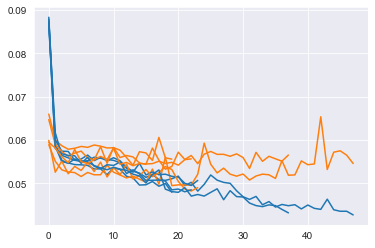

In [198]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1large, nn.MSELoss())
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 23.600+/-10.151
KFold Result: 0.056+/-0.002
MSE Result: 0.056+/-0.002
-2.2292533
2.4301252
-2.296709


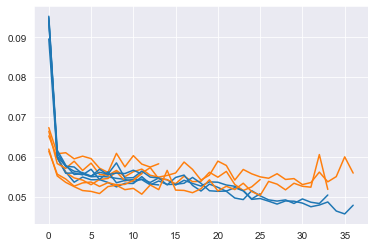

In [20]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1deeplarge, nn.MSELoss())
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 21.400+/-5.678
KFold Result: 0.072+/-0.005
MSE Result: 0.072+/-0.005
2.2678356
-0.4115131
3.7735415


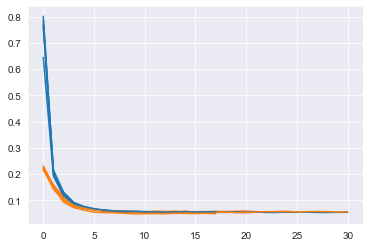

In [199]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1, nn.MSELoss(), clip=True)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 22.200+/-5.036
KFold Result: 0.061+/-0.004
MSE Result: 0.061+/-0.004
3.1715443
-0.51629776
5.584877


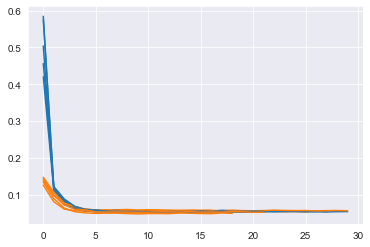

In [200]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1deep, nn.MSELoss(), clip=True)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 35.200+/-4.665
KFold Result: 0.076+/-0.007
MSE Result: 0.076+/-0.007
3.0736222
-1.0419891
4.6713667


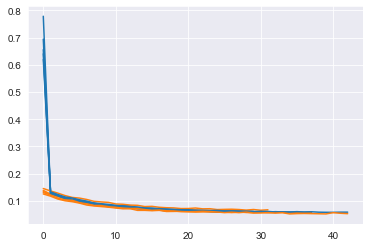

In [201]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1, nn.MSELoss(), clip=True, optim='adagrad')
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 24.000+/-4.604
KFold Result: 0.080+/-0.002
MSE Result: 0.080+/-0.002
2.109239
-0.27327564
3.3918505


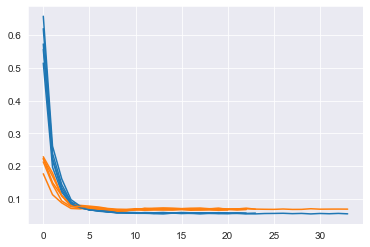

In [202]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1dp, nn.MSELoss(), clip=True)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 44.000+/-8.602
KFold Result: 0.162+/-0.032
MSE Result: 0.162+/-0.032
-15.22949
9.73053
-10.802834


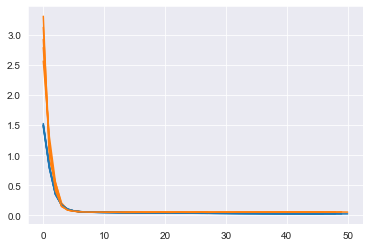

In [203]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1bn, nn.MSELoss(), clip=True)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 23.800+/-4.445
KFold Result: 0.060+/-0.002
MSE Result: 0.069+/-0.003
0.32754436
-0.16811979
-0.15546915


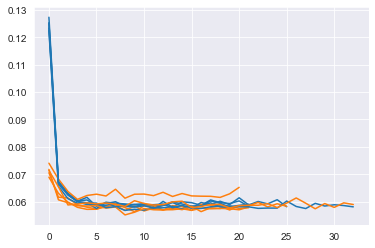

In [204]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1, WSE)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 27.800+/-12.671
KFold Result: 0.073+/-0.004
MSE Result: 0.074+/-0.003
2.617663
-0.51323247
4.1419067


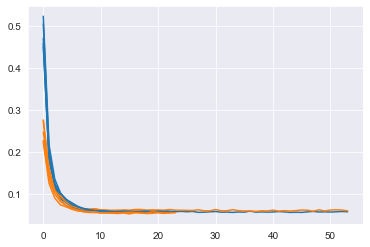

In [207]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1, WSE, clip=True)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

Epochs: 25.800+/-5.564
KFold Result: 0.057+/-0.002
MSE Result: 0.070+/-0.003
-0.060885355
-0.024269044
-0.107618235


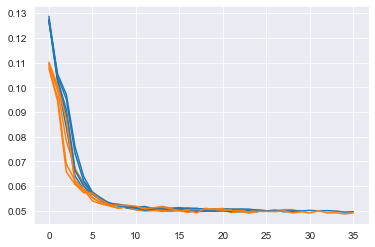

In [205]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inptmp, outtmp, Net1, nn.L1Loss())
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inptmp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inptmp)).detach().cpu().numpy()[110]).sum())

# train all

Epochs: 499.000+/-0.000
KFold Result: 0.033+/-0.001
MSE Result: 0.033+/-0.001
-12.445597
13.691553
-6.1107492


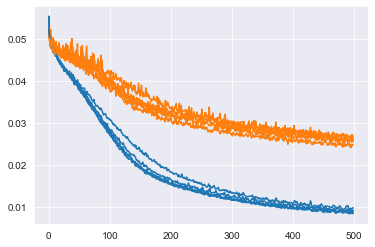

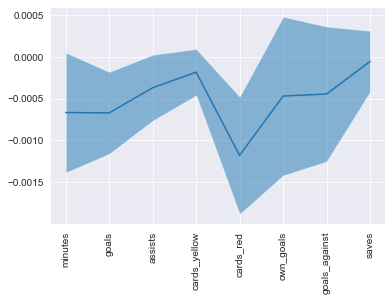

In [24]:
lst1s, nt1s, errmea, errstd, nt=runKfold(inp, out, Net1, nn.MSELoss(), clip=False, optim = 'adam', patience=500, epochs=500)
for i in range(5):
    plt.plot(lst1s[0][i], color='#1f77b4')
    plt.plot(lst1s[1][i], color='#ff7f0e')
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[1]-nt(torch.Tensor(inp)).detach().cpu().numpy()[10]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[50]-nt(torch.Tensor(inp)).detach().cpu().numpy()[60]).sum())
print((nt(torch.Tensor(inp)).detach().cpu().numpy()[100]-nt(torch.Tensor(inp)).detach().cpu().numpy()[110]).sum())
plt.show()

plt.fill_between(np.arange(len(errmea)),errmea+errstd,errmea-errstd, alpha=.5)
plt.plot(errmea)
plt.xticks(np.arange(len(errmea)),['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves'], rotation=90)
plt.show()

In [26]:
def final_training(indata, outdata, model, loss_func, clip=False, epochs=100, patience=10, lr=0.001):

    earlStop = EarlyStopping(patience=patience, keepBest=True)
    net = model(indata, outdata)
    optimizer = Adam(net.parameters(), lr=lr)

    ls, ep, ms, df, net = train(indata, outdata, None, None, net=net, optimizer=optimizer, loss_func=loss_func, epochs=epochs, earlStop=earlStop, clip=clip)

    return net

In [27]:
nt = final_training(inptmp, outtmp, Net1deep, nn.MSELoss(), clip=False, patience=1000, epochs=1000)

In [28]:
def revert_output(output,lineup=None):

    reframe=pd.DataFrame(output.reshape(50,8),
                 columns=['minutes','goals','assists','cards_yellow','cards_red','own_goals','goals_against','saves'])
    
    reframe[reframe<0] = 0
    if lineup is not None:
        reframe.index=lineup
        reframe.drop([x for x in reframe.index if x.startswith('dummy')], axis=0, inplace=True)
        
    reframe['minutes']*=90
    #byteamframe=pd.concat([reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==0].index]].sum(axis=0),
    #                    reframe.loc[[x for x in reframe.index if x in lineup[lineup['team']==1].index]].sum(axis=0)], axis=1).T
    
    byteamframe=pd.concat([reframe.iloc[:25,:].sum(axis=0),reframe.iloc[25:,:].sum(axis=0)], axis=1).T
    
    return reframe, byteamframe[byteamframe.columns[1:]]

In [29]:
pred=nt(torch.Tensor(inptmp)).detach().cpu().numpy()[3]


cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

#for x in range(len(pred)):
#    print('{:.2f}'.format(pred[x]), end='\t')
#    print('{:.2f}'.format(out[0][x]), end='\t')
#    print(cats[x%len(cats)])
#print(['{:.2f}'.format(x) for x in pred])
#print(out[0])
reframe, byteamframe = revert_output(pred)
#print(reframe)
print(byteamframe)
reframe, byteamframe = revert_output(out[3])
#print(reframe)
print(byteamframe)

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  4.046027  4.104561      4.159110   0.068433   0.056021       1.043328   
1  1.181942  1.139431      2.278188   0.174718   0.069406       4.050805   

      saves  
0  2.019987  
1  2.047021  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    4.0      4.0           4.0        0.0        0.0            1.0    2.0
1    1.0      1.0           2.0        0.0        0.0            4.0    2.0


In [245]:
pred=nt(torch.Tensor(inptmp)).detach().cpu().numpy()[0]


cats=['minutes','goals','assists','cards_yellow','cards_red','own_goals']+['goals_against','saves']

#for x in range(len(pred)):
#    print('{:.2f}'.format(pred[x]), end='\t')
#    print('{:.2f}'.format(out[0][x]), end='\t')
#    print(cats[x%len(cats)])
#print(['{:.2f}'.format(x) for x in pred])
#print(out[0])
reframe, byteamframe = revert_output(pred)
#print(reframe)
print(byteamframe)
reframe, byteamframe = revert_output(out[0])
#print(reframe)
print(byteamframe)

      goals   assists  cards_yellow  cards_red  own_goals  goals_against  \
0  1.570974  1.130650      2.305251   0.181520   0.124656       1.737080   
1  1.362143  1.026402      2.780016   0.322737   0.215887       1.503881   

      saves  
0  2.678197  
1  3.405015  
   goals  assists  cards_yellow  cards_red  own_goals  goals_against  saves
0    1.0      1.0           3.0        0.0        0.0            0.0    3.0
1    0.0      0.0           1.0        0.0        0.0            1.0    5.0
